![Ames Iowa](../images/Ames_Sign2.jpg)


# Predicting Housing Prices

The goal of this notebook is to try and predict the `SalePrice` of homes in Ames, Iowa. As per the Kaggle rules this will require some **feature engineering** as well as the usage of **Random Forest** models.

The approach I will take is as follows:
1. Import the data
2. Identify any strong correlations in the data
3. Determine if there are missing values
4. Remove features that are mostly null
5. Impute remaining features with median data (numerical) and most frequent data (categorical)
6. Run dat Random Forest

The data gathered was provided by Kaggle. The kaggle competition page can be found [here](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).


## Import all the goodies

In [1]:
# data handling and prediction
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals.six import StringIO
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from scipy import stats

#visualization
%matplotlib inline
import seaborn as sns
from IPython.display import Image
import matplotlib.pyplot as plt
import pydotplus

In [2]:
housing_data_train = pd.read_csv("../data/train.csv",na_values='NA')
housing_data_test = pd.read_csv("../data/test.csv",na_values='NA') #does not contain Saleprice column which is what we predict
# Convert the headers to lowercase
housing_data_train.columns = map(str.lower, housing_data_train.columns)
housing_data_test.columns = map(str.lower, housing_data_test.columns)

## Let's take a look

In [3]:
housing_data_train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Stats for the numerical data

In [4]:
housing_data_train.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,3ssnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
housing_data_train.saleprice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

Ok so the average Saleprice of a home is almost 180K.

## Correlation
Lets take a look at the correlation of the features to see if we can identify the important ones

In [6]:
housing_data_train.corr()["saleprice"].sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
1stflrsf         0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
2ndflrsf         0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
screenporch      0.111447
poolarea         0.092404
mosold           0.046432
3ssnporch        0.044584
bsmtfinsf2      -0.011378
bsmthalfbath    -0.016844
miscval         -0.021190
id              -0.021917
lowqualfinsf    -0.025606
yrsold          -0.028923
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.128578
kitchenabvgr    -0.135907
Name: salepr

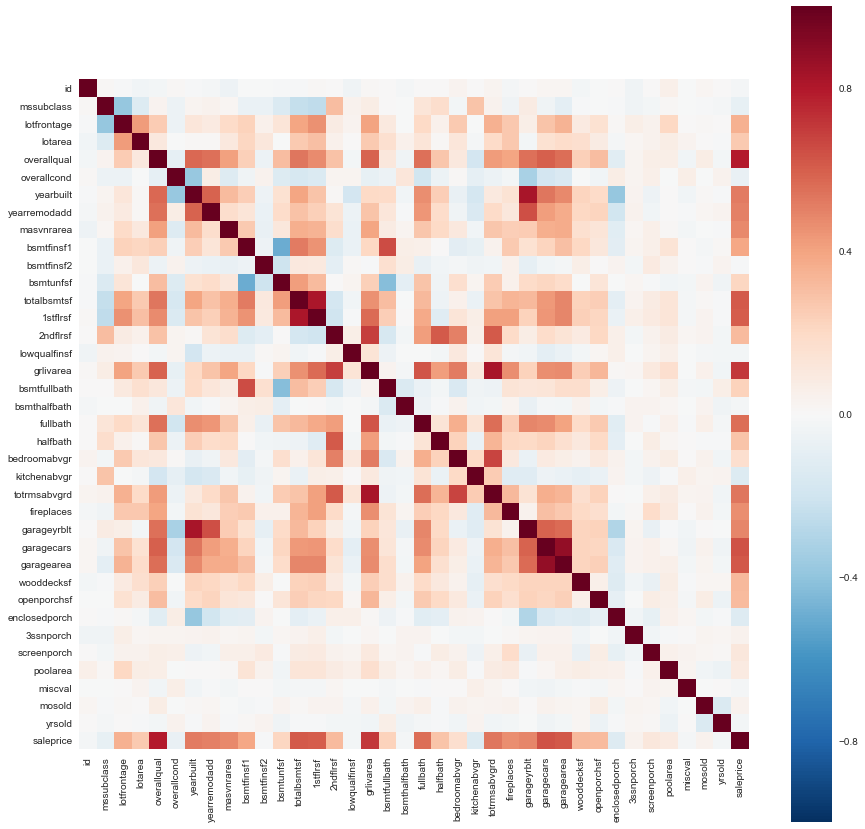

In [7]:
housing_corr = housing_data_train.corr()
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(housing_corr, square=True)

Let's select the fields with a correlation of .4 or higher and see how the relationship to SalePrice looks.

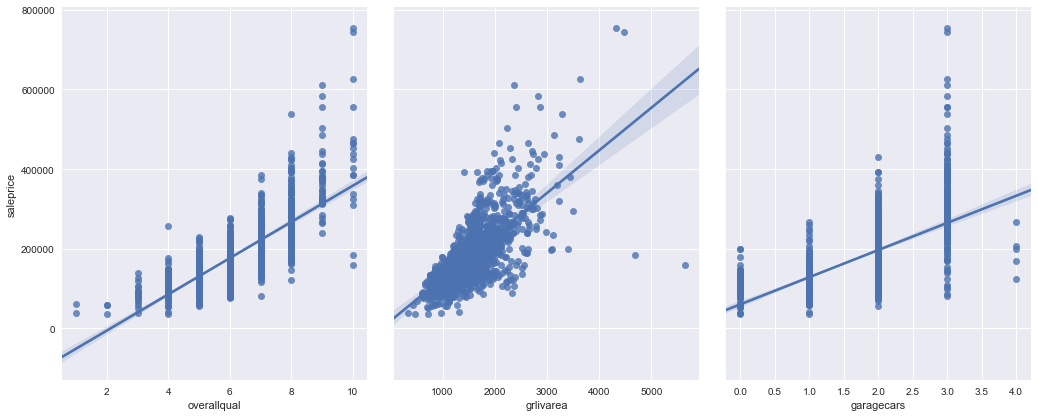

In [8]:
sns.pairplot(housing_data_train, x_vars=['overallqual','grlivarea','garagecars'], y_vars='saleprice',
             size=6, aspect=0.8, kind='reg')

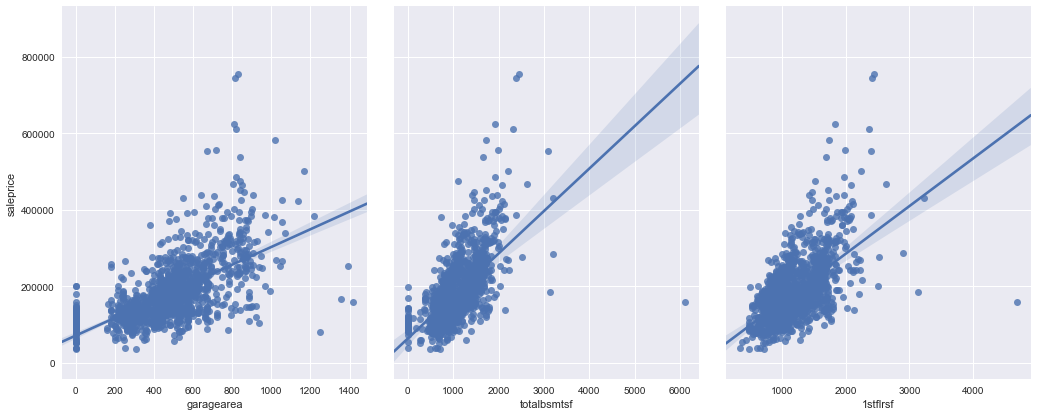

In [9]:
sns.pairplot(housing_data_train, x_vars=['garagearea','totalbsmtsf',
                      '1stflrsf'], y_vars='saleprice',
             size=6, aspect=0.8, kind='reg')

## Split Numeric and Categorical Data

In [11]:
print(housing_data_train.dtypes.value_counts())

object     43
int64      35
float64     3
dtype: int64


In [12]:
housing_data_train_numeric = housing_data_train.select_dtypes(include=['int64','float64'])

In [13]:
housing_data_train_categories = housing_data_train.select_dtypes(exclude=['int64','float64'])

## Review and Impute Missing Data

In [15]:
categorical_null = (housing_data_train_categories.isnull().sum())
categorical_null = categorical_null[categorical_null>0]
categorical_null.sort_values(ascending=False,inplace=True)
print(categorical_null)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
garagecond        81
garagequal        81
garagefinish      81
garagetype        81
bsmtfintype2      38
bsmtexposure      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrtype         8
electrical         1
dtype: int64


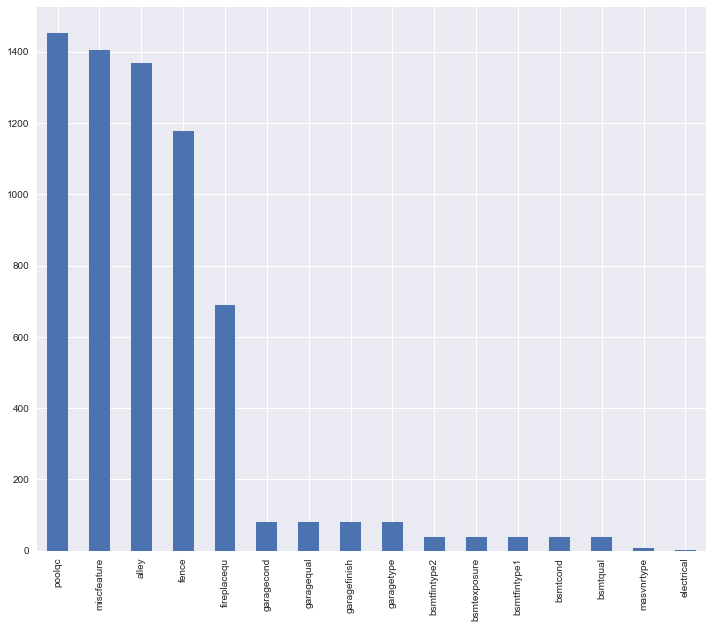

In [16]:

categorical_null.plot(kind='bar',figsize=(12,10))

Since some of our features are missing a large percentage of their data we will just drop them. Originally I also removed `fireplacequ` but the model was slightly more accurate if I left it in.

In [17]:
drop_columns = ['alley','poolqc','fence','miscfeature']
for column in drop_columns:
    housing_data_train_categories = housing_data_train_categories.drop(column, axis=1)

Now let's check the null data in the numeric features.

In [18]:
numeric_percent_null = housing_data_train_numeric.isnull().sum()
numeric_percent_null = numeric_percent_null[numeric_percent_null>0]
numeric_percent_null = numeric_percent_null.sort_values(ascending=False)
print(numeric_percent_null)

lotfrontage    259
garageyrblt     81
masvnrarea       8
dtype: int64


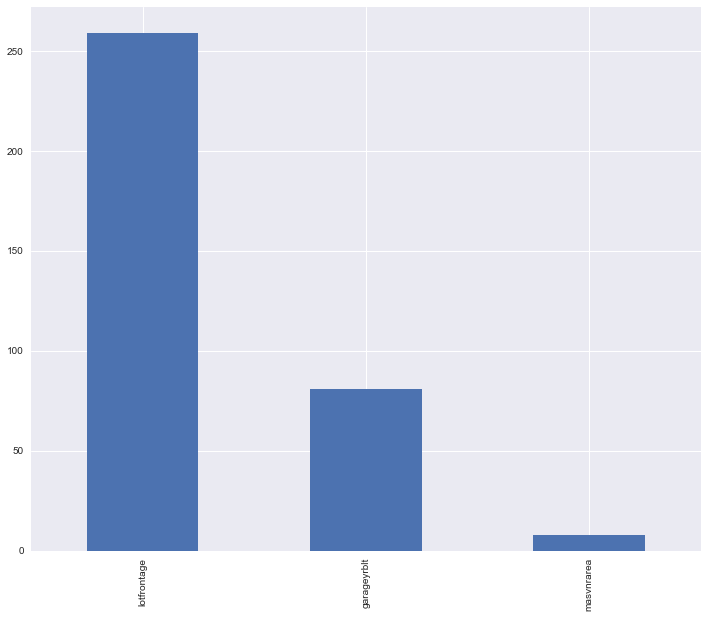

In [19]:
numeric_percent_null.plot(kind='bar', figsize=(12,10))

Removing lotfrontage since there are more than 50 fields missing

In [20]:
housing_data_train_numeric = housing_data_train_numeric.drop(['lotfrontage'], axis=1)

## Impute numeric data with the mean value

In [21]:
mean_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_mean_filled = housing_data_train_numeric.fillna(mean_per_column,axis=0)
#numeric_mean_filled.isnull().sum()

In [22]:
housing_data_train_categories.describe()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,770,1379,1379,1379,1379,1460,1460,1460
unique,5,2,4,4,2,5,3,25,9,8,...,4,7,5,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1151,1454,925,1311,1459,1052,1382,225,1260,1445,...,735,1360,380,870,605,1311,1326,1340,1267,1198


## Impute numeric data with median value

In [23]:
median_per_column = housing_data_train_numeric.apply(lambda x: x.mean(),axis=0)
numeric_median_filled = housing_data_train_numeric.fillna(median_per_column,axis=0)

## Impute categorical data with most frequent value

In [24]:
def get_most_frequent_value (column):
    return column.value_counts().index[0]

most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)

In [25]:
most_frequent_values = housing_data_train_categories.apply(get_most_frequent_value,axis=0)
#print("Most frequent value in each column:\n"),most_frequent_values

In [26]:
categorical_most_frequent = housing_data_train_categories.fillna(most_frequent_values,axis=0)

In [27]:
#categorical_most_frequent.isnull().sum()

In [28]:
special_missing_category = housing_data_train_categories.fillna("missing")
special_missing_category.head()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,missing,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


Transform the categorical fields using get_dummies function

In [29]:
categorical_list = categorical_most_frequent.columns.tolist()
housing_dummies = pd.get_dummies(categorical_most_frequent,columns=categorical_list)
housing_dummies.head()

,mszoning_C (all),mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Grvl,street_Pave,lotshape_IR1,lotshape_IR2,lotshape_IR3,...,saletype_ConLw,saletype_New,saletype_Oth,saletype_WD,salecondition_Abnorml,salecondition_AdjLand,salecondition_Alloca,salecondition_Family,salecondition_Normal,salecondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


## Try label encoder instead

In [30]:
housing_labels = categorical_most_frequent.apply(LabelEncoder().fit_transform)

In [31]:
housing_labels_special = special_missing_category.apply(LabelEncoder().fit_transform)

In [32]:
housing_labels.head()

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,...,kitchenqual,functional,fireplacequ,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
0,3,1,3,3,0,4,0,5,2,2,...,2,6,2,1,1,4,4,2,8,4
1,3,1,3,3,0,2,0,24,1,2,...,3,6,4,1,1,4,4,2,8,4
2,3,1,0,3,0,4,0,5,2,2,...,2,6,4,1,1,4,4,2,8,4
3,3,1,0,3,0,0,0,6,2,2,...,2,6,2,5,2,4,4,2,8,0
4,3,1,0,3,0,2,0,15,2,2,...,2,6,4,1,1,4,4,2,8,4


### Join the datasets back together

In [33]:
all_housing_data = numeric_median_filled.merge(housing_dummies, left_index=True,
                                            right_index=True)

In [34]:
housing_X_labels = numeric_median_filled.merge(housing_labels, left_index=True,
                                            right_index=True)

In [35]:
housing_X_labels_special = numeric_median_filled.merge(housing_labels_special, left_index=True,
                                            right_index=True)

In [36]:
housing_X_labels = housing_X_labels.drop('saleprice',axis=1)


In [37]:
housing_X_labels_special = housing_X_labels_special.drop('saleprice',axis=1)

In [38]:
housing_X = all_housing_data.copy()

In [39]:
housing_y = housing_data_train_numeric.saleprice

In [40]:
housing_X = housing_X.drop("saleprice",axis=1)

## Grid Search with Label Encoded Categorical Variables

In [41]:
estimators_range = [10,50,100]
rf_grid = RandomForestRegressor(random_state=123,n_jobs=-1)
max_depth_range = range(1,25)
min_leaf_range = range(1,2)
param_grid = dict(max_depth=max_depth_range,min_samples_leaf = min_leaf_range,
                  n_estimators=estimators_range)
grid = GridSearchCV(rf_grid,param_grid, cv=20, scoring='r2')
grid.fit(housing_X_labels, housing_y)

GridSearchCV(cv=20, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': range(1, 25), 'min_samples_leaf': range(1, 2), 'n_estimators': [10, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='r2', verbose=0)

In [43]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.cv_results_['mean_test_score'])
grid_mean_scores = grid.cv_results_['mean_test_score']
print(grid_mean_scores)

0.864115316755
{'max_depth': 18, 'min_samples_leaf': 1, 'n_estimators': 50}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=123,
           verbose=0, warm_start=False)
[ 0.48634104  0.47083252  0.48627532  0.65044441  0.6543642   0.6579168
  0.73788289  0.74122503  0.74233922  0.78918863  0.79343269  0.79488328
  0.82261701  0.82248029  0.82366409  0.82994226  0.83981554  0.84040812
  0.84121207  0.85080855  0.84986758  0.84811509  0.85528918  0.85440633
  0.84400935  0.85741193  0.85617303  0.85415625  0.8601601   0.85979111
  0.85017494  0.86078053  0.85953295  0.85125586  0.86222588  0.8607594
  0.84541911  0.85783273  0.85991635  0.84773261  0.86152726  0.86046611
  0.85170238  0.85940397  0.86054415  0.84925052  0.86019656

In [44]:
rf_grid = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20,oob_score=True)
rf_grid.fit(housing_X_labels,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=True, random_state=123,
           verbose=0, warm_start=False)

In [45]:
rf_grid.oob_score_

0.86105387508690745

In [46]:
print("RMSE:",np.sqrt(mean_squared_error(housing_y, rf_grid.predict(housing_X_labels))))

RMSE: 10415.3085425


## Test with Dummy Indicator Variables

In [47]:
rf_dummies = RandomForestRegressor(n_estimators=50,random_state=123,n_jobs=-1,max_depth=20,oob_score=True)
rf_dummies.fit(housing_X,housing_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=True, random_state=123,
           verbose=0, warm_start=False)

In [48]:
print("RMSE:",np.sqrt(mean_squared_error(housing_y, rf_dummies.predict(housing_X))))

RMSE: 10739.6510819


Looks like the Lavel encoder works better than Indicator Variables so we will use that with the test data

## Feature Importance

In [49]:
feature_importance = pd.DataFrame({'feature':housing_X_labels.columns.tolist(),
              'importance':rf_grid.feature_importances_}) 

In [52]:
feature_importance_sorted = feature_importance.sort_values('importance', ascending=False)
feature_importance_sorted.head(10)

,feature,importance
3,overallqual,0.575015
15,grlivarea,0.112389
11,totalbsmtsf,0.042511
13,2ndflrsf,0.039737
8,bsmtfinsf1,0.025077
12,1stflrsf,0.024237
25,garagecars,0.023670
2,lotarea,0.014612
26,garagearea,0.014506
5,yearbuilt,0.009455


## DOING ALL OF THIS AGAIN TO THE Testing SET

In [53]:
housing_data_test_numeric = housing_data_test.select_dtypes(include=['int64','float64'])
housing_data_test_categories = housing_data_test.select_dtypes(exclude=['int64','float64'])

In [54]:
percent_null = (housing_data_test_categories.isnull().sum())
percent_null.sort_values(ascending=False)

poolqc           1456
miscfeature      1408
alley            1352
fence            1169
fireplacequ       730
garagecond         78
garagequal         78
garagefinish       78
garagetype         76
bsmtcond           45
bsmtqual           44
bsmtexposure       44
bsmtfintype2       42
bsmtfintype1       42
masvnrtype         16
mszoning            4
utilities           2
functional          2
kitchenqual         1
saletype            1
exterior2nd         1
exterior1st         1
heating             0
condition2          0
street              0
paveddrive          0
lotshape            0
landcontour         0
lotconfig           0
landslope           0
neighborhood        0
condition1          0
roofstyle           0
bldgtype            0
housestyle          0
heatingqc           0
roofmatl            0
exterqual           0
extercond           0
foundation          0
electrical          0
centralair          0
salecondition       0
dtype: int64

In [55]:
numeric_percent_null = (housing_data_test_numeric.isnull().sum())
numeric_percent_null.sort_values(ascending=False)

lotfrontage      227
garageyrblt       78
masvnrarea        15
bsmthalfbath       2
bsmtfullbath       2
garagearea         1
bsmtfinsf1         1
bsmtfinsf2         1
bsmtunfsf          1
totalbsmtsf        1
garagecars         1
overallqual        0
overallcond        0
yearbuilt          0
yearremodadd       0
lowqualfinsf       0
lotarea            0
mssubclass         0
1stflrsf           0
2ndflrsf           0
yrsold             0
grlivarea          0
mosold             0
fullbath           0
halfbath           0
bedroomabvgr       0
kitchenabvgr       0
totrmsabvgrd       0
fireplaces         0
wooddecksf         0
openporchsf        0
enclosedporch      0
3ssnporch          0
screenporch        0
poolarea           0
miscval            0
id                 0
dtype: int64

In [56]:
category_drop = ['alley','poolqc','fence','miscfeature']
for column in category_drop:
    housing_data_test_categories = housing_data_test_categories.drop(column, axis=1)

In [57]:
housing_data_test_numeric = housing_data_test_numeric.drop(['lotfrontage'], axis=1)

In [58]:
test_median_per_column = housing_data_test_numeric.apply(lambda x: x.median(),axis=0)
test_median_filled = housing_data_test_numeric.fillna(test_median_per_column,axis=0)

In [59]:
test_most_frequent_values = housing_data_test_categories.apply(get_most_frequent_value,axis=0)
test_most_frequent = housing_data_test_categories.fillna(test_most_frequent_values,axis=0)

In [60]:
housing_labels_test = test_most_frequent.apply(LabelEncoder().fit_transform)

In [61]:
housing_X_test = test_median_filled.merge(housing_labels_test, left_index=True,
                                            right_index=True)

In [62]:
housing_X_labels.shape

(1460, 75)

In [63]:
housing_X_test.shape

(1459, 75)

In [64]:
housing_X_test['saleprice'] = rf_grid.predict(housing_X_test).astype('int')

In [65]:
pred_columns = ['id','saleprice']
housing_X_test_labels_pred = housing_X_test[pred_columns]

In [66]:
housing_X_test_labels_pred.shape

(1459, 2)

In [67]:
housing_X_test_labels_pred.to_csv('../data/submission.csv',index=False)

## Submit Predictions to Kaggle

![kaggle_submission](../images/kaggle.jpg)

## Things I noticed
1. The more features I removed the less accurate the model became
2. Label encoder is better than using the get_dummies function
3. I have no idea how to use GradientBoostRegressor
4. Scaling the data does not matter with Random Forest
5. Using the Median to impute numerical data rather than Mean was more accurate. Most likely due to all of the outliers.